In [1]:
import numpy as np
import  matplotlib.pyplot as plt
import scipy.special as sp

In [2]:
def source(no_of_users,no_of_bits):
    return np.random.randint(0, 2, (no_of_users,no_of_bits))
no_of_users=2
no_of_bits=8000
msg_bits1=source(no_of_users,no_of_bits)

print("msg\n",msg_bits1)
print(len(msg_bits1))

msg
 [[1 0 1 ... 0 1 1]
 [1 1 1 ... 1 0 0]]
2


In [3]:
def mod(bits):
    mapping = {
        (0,0):1+1j,
        (0,1):-1+1j,
        (1,0):1-1j,
        (1,1):-1-1j
    }
    #modulation
    symbols=np.array([])
    for i in range(0,len(bits),1):
        for j in range(0,len(bits[0]),2):
            bit_pair=(bits[i][j],bits[i][j+1])
            symbols=np.append(symbols,mapping[bit_pair])
        #print("mod",modulated_bits)
    return symbols
symbols=mod(msg_bits1).reshape(no_of_users,int(no_of_bits/2))
print(symbols)

[[ 1.-1.j -1.-1.j  1.+1.j ... -1.-1.j  1.-1.j -1.-1.j]
 [-1.-1.j  1.-1.j -1.-1.j ... -1.-1.j -1.-1.j  1.+1.j]]


In [4]:
def awgn(symbols, snr_db):
    # print(symbols)
    combined_symbols=np.sum(symbols,axis=0)
    # print(combined_symbols)
    signal_power = np.mean(np.abs(combined_symbols)**2)
    # print("signal power",signal_power)

    snr_linear = 10**(snr_db / 10.0)
    # print(snr_linear)
    
    noise_variance =  signal_power / (2 * snr_linear)
    # print("noise_var",noise_variance)

    noise = np.sqrt(noise_variance) * ((np.random.randn(len(combined_symbols))) + 1j* (np.random.randn(len(combined_symbols))) )
    # print(noise)

    
    return combined_symbols + noise

snr_db=np.arange(0,1,1)
received_signal=awgn(symbols,snr_db)
print(received_signal)

[-0.94361144-0.75670568j -0.12454557-1.9860606j   2.10401358+0.79200834j
 ... -0.59891636-5.32029682j  0.66333126-1.51230214j
 -0.23060539+0.04676505j]


In [5]:
def demod(received_signal):
    # Define the possible symbols
    symbols = [
        2 + 2j, 2j, 0, 2,
        -2 + 2j, -2, -2 - 2j, -2j,
        2 - 2j
    ]

    # Demodulation
    demodulated_symbols = []
    for i in received_signal:
        # print(i)
        closest_symbol = min(symbols, key=lambda s: np.abs(i - s))
        demodulated_symbols.append(closest_symbol)

    return np.array(demodulated_symbols)

demod_symbols=demod(received_signal)
print(demod_symbols)

[ 0.+0.j -0.-2.j  2.+0.j ... -0.-2.j -0.-2.j  0.+0.j]


In [6]:
def calculate_ber(msg,rec,no_of_users,no_of_bits):
    sym1=mod(msg)
    combined_symbols=np.sum(symbols,axis=0)
    
    
    # print(msg)
    # msg_sum=np.sum(msg,axis=0)
    # print("\n",msg_sum)
    # print("\n",rec)

    ber=np.mean(combined_symbols!=rec)
    return ber 
BER=calculate_ber(msg_bits1,demod_symbols,no_of_users,no_of_bits)
print(BER)

0.59475


In [7]:
def simulate(snr_db_range, msg_bits,no_of_users,no_of_bits):
    ber = []
    # print("msg\n",msg_bits)

    for snr_db in snr_db_range:
        print("snr=",snr_db)
        # Modulation        symbols-->bitsy])
        transmitted_symbols =mod(msg_bits).reshape(no_of_users,int(no_of_bits/2))
        # print("TX\n",transmitted_symbols)
        
        
        #channel output = bits+noie
        received_symbols = awgn(transmitted_symbols,snr_db)
        # print("sum(x)+n\n",received_symbols)
        
        # Demodulate the received signal        noisy_bits-->symbols
        demodulated_symbols =demod(received_symbols)
        # print("demod\n",demodulated_symbols)
    
        # Calculate BER
        ber.append(calculate_ber(msg_bits, demodulated_symbols,no_of_users,no_of_bits))
        # print(ber)
        # print("\n\n")

    return ber

snr_db_range=np.arange(0,12,1)
ser_qpsk_sum=simulate(snr_db_range,msg_bits1,no_of_users,no_of_bits)
print(ser_qpsk_sum)

snr= 0
snr= 1
snr= 2
snr= 3
snr= 4
snr= 5
snr= 6
snr= 7
snr= 8
snr= 9
snr= 10
snr= 11
[0.58825, 0.5305, 0.4965, 0.41375, 0.358, 0.28125, 0.213, 0.147, 0.09975, 0.06875, 0.0335, 0.01675]


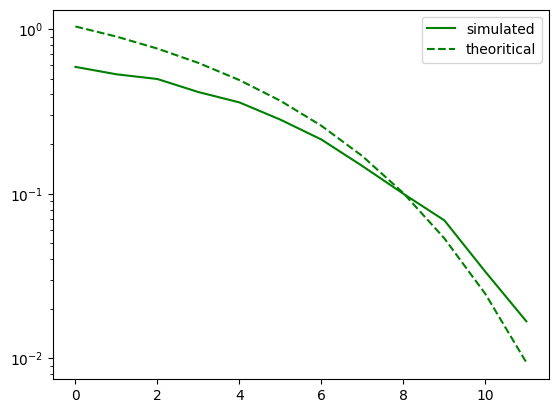

In [8]:
snr_lin=10**(snr_db_range/10)
ser_qpsk_sum_theory=2.5*sp.erfc(np.sqrt(snr_lin/3))
plt.semilogy(snr_db_range,ser_qpsk_sum,  linestyle='-', color="g", label='simulated')
plt.semilogy(snr_db_range, ser_qpsk_sum_theory,  linestyle='--', color='g', label='theoritical')
plt.legend()
plt.show()